In [1]:
# Using scikit-learn to perform K-Means clustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs   
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Data and Datasets
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine

# Validation methods
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Metrics
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
 # the Random Classifier python file in the 'classifiers' folder

# Plotting & utils
import pprint
import matplotlib.pyplot as plt
import numpy as np
from time import time
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

# Data and Datasets
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine

# Validation methods
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

# Metrics
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# Classifiers
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

# Hyper-parameter optimisation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Feature selection & feature engineering
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

# Stats
from scipy.stats import randint as sp_randint
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import shapiro     # Shapiro Wilk
from scipy.stats import normaltest  # D’Agostino’s K^2
from scipy.stats import anderson    # Anderson-Darling
from scipy.stats import ttest_ind    # independent student t-test; assumes normality
from scipy.stats import mannwhitneyu # non-parametric; doesn't assume normality

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import SVG

from IPython.display import display
from sklearn.tree import export_graphviz

# Utils
import pprint
import numpy as np
from time import time


In [2]:
def plot_cluster_graph(X, y_pred, core_samples_mask, algorithm_name, n_clusters, cluster_centres=None):
    
    plt.rcParams.update({'font.size': 12, 'figure.figsize': (12, 9)}) # set font and plot size to be larger

    unique_labels = set(y_pred)

    colors = [plt.cm.rainbow(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [1, 1, 1, 1] # white for noise

        class_member_mask = (y_pred == k)

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=14)

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6)

    # plots centroids, if provided
    if cluster_centres is not None:
        plt.plot(cluster_centres[:,0], cluster_centres[:,1], 'o', mew=10, ms=20, alpha=0.5)
    
    plt.title('%s with %d clusters' % (algorithm_name, n_clusters))
    plt.show()

In [3]:
result_df = pd.DataFrame(columns=['Model','Validation Method','Accuracy','STDEV', 'Training time (s)', 'Testing time (s)'])

def add_result(model_name, validation_method, accuracy_list, fit_time_list, predict_time_list):
    """
    Add a result row to a pandas dataframe (created above) for a model with name (model_name),
    the validation method used, and the results (accuracy_list, fit_time_list, and predict_time_list).
    """
    global result_df # doing this to be able to access the gloval dataframe defined above the function
    
    new_row = {'Model':model_name, 
               'Validation Method':validation_method, 
               'Accuracy':accuracy_list.mean(), 
               'STDEV':accuracy_list.std(),
               'Training time (s)':fit_time_list.mean(), 
               'Testing time (s)':predict_time_list.mean()}
    result_df = result_df.append(new_row, ignore_index=True)
    
    return result_df

In [4]:
def hold_out_validation(X, y, model, num_runs=1000, test_size=0.2):
    """
    Performs hold-out validation of a given model on the dataset provided (X, y).
    The default number of runs is 1000, and the default training/test split is 80/20.
    Returns 3 lists: accuracy, training time and testing time
    """
    
    # array(s) for storing performance metrics
    accuracy_list = np.array([])
    fit_time_list = np.array([])
    predict_time_list = np.array([])
    
    for x in range(num_runs):
        # Hold-out validation - 80% training and 20% testing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=None)

        # Training and testing the model
        start_time = time()
        model.fit(X_train, y_train)
        end_time = time()
        fit_time_list = np.append(fit_time_list, end_time-start_time)
        
        # Testing the model
        start_time = time()
        y_pred = model.predict(X_test)
        end_time = time()
        predict_time_list = np.append(predict_time_list, end_time-start_time)

        # Appending performance metrics to arrays created above
        accuracy_list = np.append(accuracy_list, accuracy_score(y_test, y_pred))
    
    return accuracy_list, fit_time_list, predict_time_list

In [5]:
def print_stats(n_clusters, n_noise, X, y, y_pred):
    print('Estimated number of clusters: %d' % n_clusters)
    print('Estimated number of noise points: %d' % n_noise)
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, y_pred))
    print("Completeness: %0.3f" % metrics.completeness_score(y, y_pred))
    
    # and some extra metrics not explicitly mentioned in the lab tasks
    print("V-measure: %0.3f" % metrics.v_measure_score(y, y_pred))
    print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, y_pred))
    print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, y_pred))
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, y_pred))

In [6]:
df = pd.read_csv('Documents/heart-disease2.csv')

In [7]:
#df_1 = df.dropna(how='all')
df_1 = df.drop(columns=['ST segment', 'Thal', "Number of major vessels"])
df_1[df_1 < 0] = 0
(df_1 < 0).values.any()

False

In [8]:
df_1.isnull().sum()
ds = df_1.isin([np.inf, -np.inf])
print(ds.sum())

Age                             0
Gender                          0
Chest pain type                 0
Resting blood pressure          0
Serum cholesterol               0
Fasting blood sugar             0
Resting electrocardiographic    0
Maximum heart rate              0
Exercise induced angina         0
ST depression                   0
class                           0
dtype: int64


In [9]:
age = df_1["Age"]
max_ = df_1["Maximum heart rate"]
data = {"age": age, "maximum heart rate": max_}
X = pd.DataFrame(data)
X = np.array(X)

C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


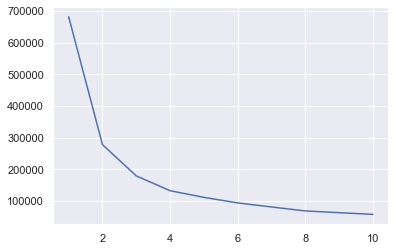

In [10]:
# Elbow method to see how many clusters is optimal

wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters= i,
    init = 'k-means++', max_iter=300, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11), wcss)

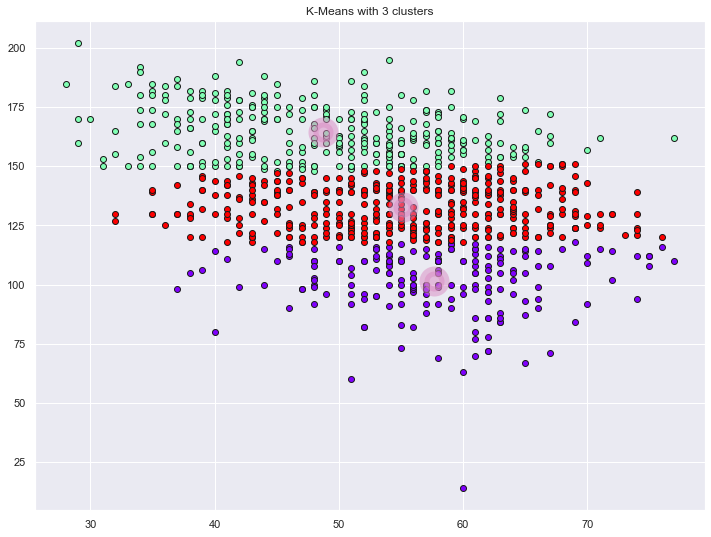

In [11]:
model = KMeans(n_clusters=3)
model = model.fit(X)
labels = model.labels_
cluster_centres = model.cluster_centers_

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - Not applicable to K-Means, as it doesn't have a concept of 'core' samples
# - So this is just an Numpy Array of 'False'
core_samples_mask = np.zeros_like(labels, dtype=bool)

# Print stats and plot graph

plot_cluster_graph(X, labels, core_samples_mask, 'K-Means', n_clusters_, cluster_centres=cluster_centres)

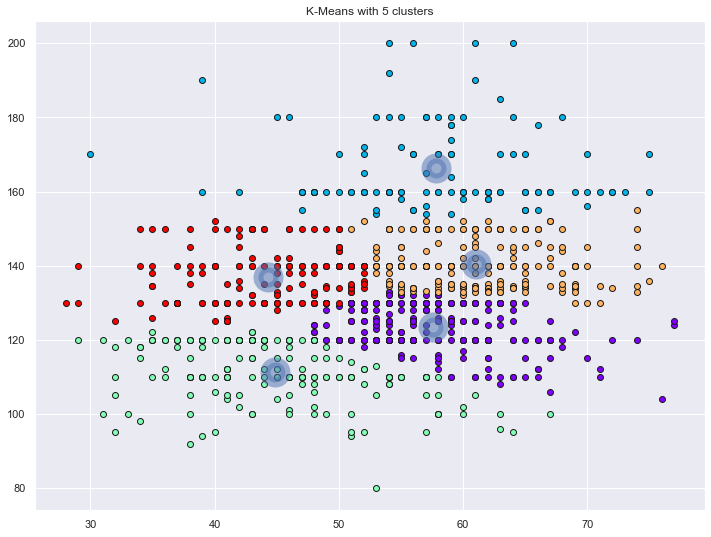

In [12]:
a = df_1["Age"]
b = df_1["Resting blood pressure"]
data = {"a": a, "b": b}
X = pd.DataFrame(data)
X = np.array(X)


model = KMeans(n_clusters=5)
model = model.fit(X)
labels = model.labels_
cluster_centres = model.cluster_centers_

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - Not applicable to K-Means, as it doesn't have a concept of 'core' samples
# - So this is just an Numpy Array of 'False'
core_samples_mask = np.zeros_like(labels, dtype=bool)

# Print stats and plot graph

plot_cluster_graph(X, labels, core_samples_mask, 'K-Means', n_clusters_, cluster_centres=cluster_centres)

DBSCAN(eps=2, min_samples=15)


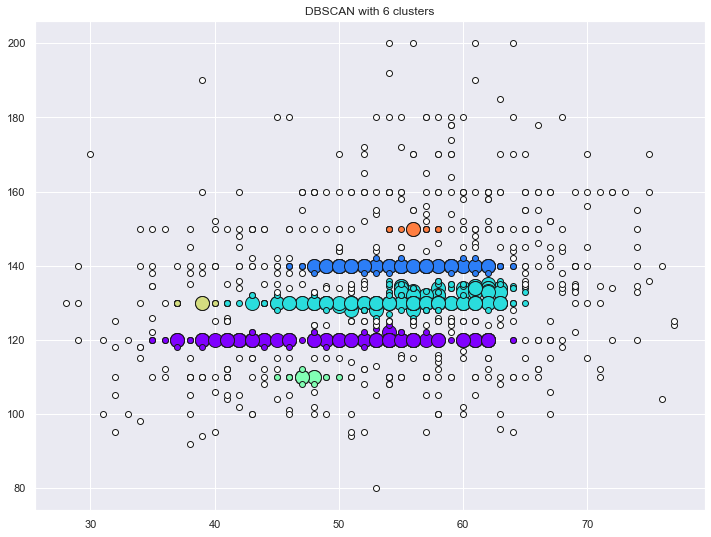

In [13]:
model = DBSCAN(eps=2, min_samples=15)
model = model.fit(X)
labels = model.labels_
y_pred = model.fit(X)
print(y_pred)

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - First creates a NumPy array of False entries
# - Then sets the entries for the core instances to True
core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True

plot_cluster_graph(X, labels, core_samples_mask, 'DBSCAN', n_clusters_)

In [14]:
age = df_1["Age"]
class1 = df_1["Serum cholesterol"]
data = {"Age": age, "class": class1}
X = pd.DataFrame(data)
X = np.array(X)

DBSCAN(eps=1, min_samples=10)


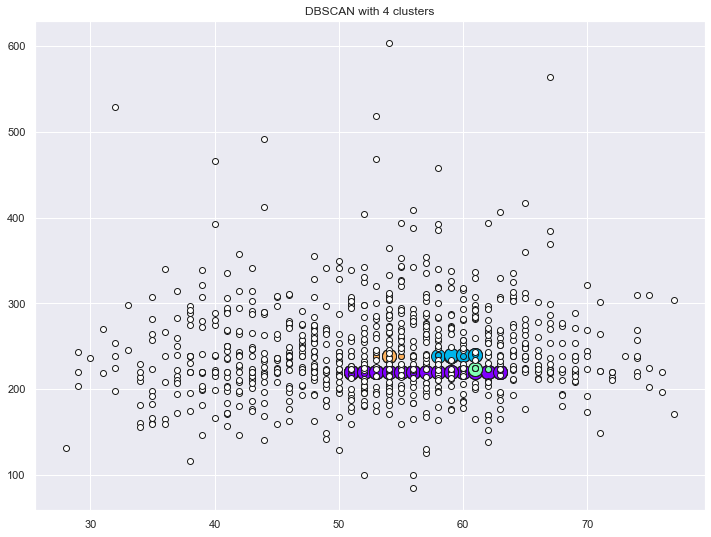

In [15]:
model = DBSCAN(eps=1, min_samples=10)
model = model.fit(X)
labels = model.labels_
y_pred = model.fit(X)
print(y_pred)

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - First creates a NumPy array of False entries
# - Then sets the entries for the core instances to True
core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True

plot_cluster_graph(X, labels, core_samples_mask, 'DBSCAN', n_clusters_)

DBSCAN(eps=3, min_samples=10)


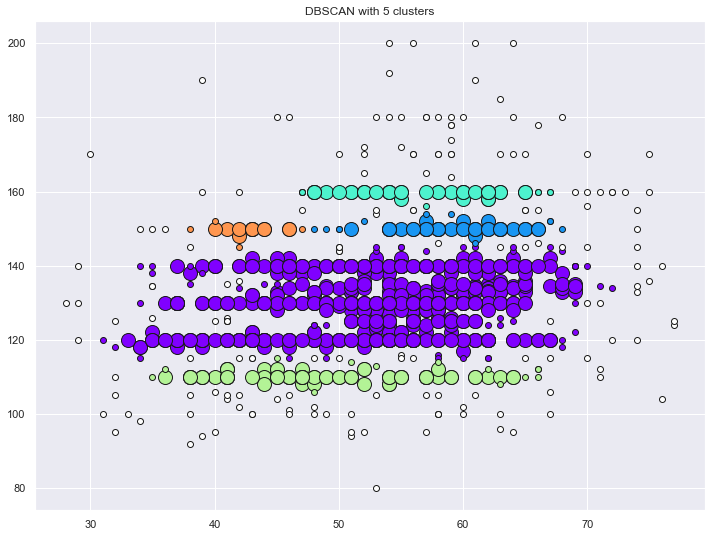

In [16]:
a = df_1["Age"]
b = df_1["Resting blood pressure"]
data = {"a": a, "b": b}
X = pd.DataFrame(data)
X = np.array(X)


model = DBSCAN(eps=3, min_samples=10)
model = model.fit(X)
labels = model.labels_
y_pred = model.fit(X)
print(y_pred)

# Number of clusters in labels, ignoring noise (if present)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Create a mask for visualising the core samples in each cluster
# - First creates a NumPy array of False entries
# - Then sets the entries for the core instances to True
core_samples_mask = np.zeros_like(model.labels_, dtype=bool)
core_samples_mask[model.core_sample_indices_] = True

plot_cluster_graph(X, labels, core_samples_mask, 'DBSCAN', n_clusters_)

C:\Users\Dawid\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


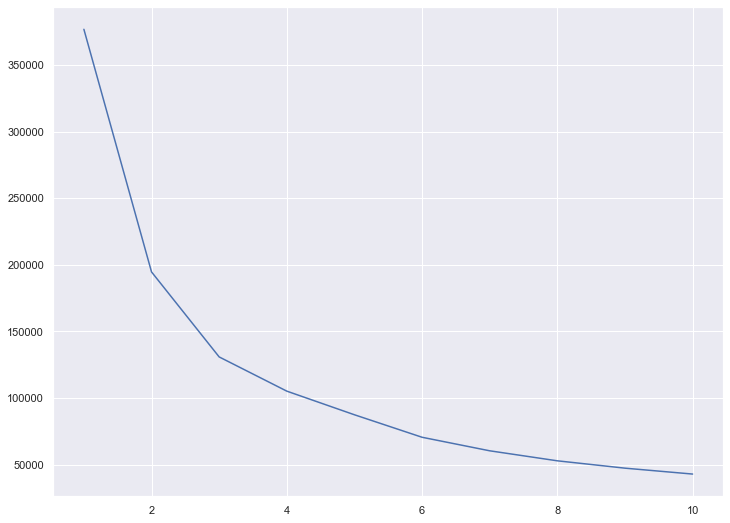

In [17]:
# Elbow method to see how many clusters is optimal
a = df_1["Age"]
b = df_1["Resting blood pressure"]
data = {"a": a, "b": b}
X = pd.DataFrame(data)
X = np.array(X)


wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters= i,
    init = 'k-means++', max_iter=300, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11), wcss)

In [18]:
df.describe(include="all")


,Age,Gender,Chest pain type,Resting blood pressure,Serum cholesterol,Fasting blood sugar,Resting electrocardiographic,Maximum heart rate,Exercise induced angina,ST depression,ST segment,Number of major vessels,Thal,class
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,611.000000,309.000000,434.000000,920.000000
mean,53.510870,0.789130,3.250000,132.382174,242.546739,0.150000,0.603261,137.027174,0.400000,0.903370,1.770867,0.676375,5.087558,0.995652
std,9.424685,0.408148,0.930969,17.925276,52.481532,0.357266,0.805443,25.560279,0.490164,1.058574,0.619256,0.935653,1.919075,1.142693
min,28.000000,0.000000,1.000000,80.000000,85.000000,0.000000,0.000000,14.000000,0.000000,-2.600000,1.000000,0.000000,3.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,217.750000,0.000000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,233.000000,0.000000,0.000000,139.000000,0.000000,0.800000,2.000000,0.000000,6.000000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000,1.000000,7.000000,2.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000


In [19]:
df_1.shape

(920, 11)

In [20]:
b = []

for a in df["Gender"]:
    if a == 1:
        b.append(a)
c = len(b)
d = 720 / 920
d

0.782608695652174

Text(0.5, 1.0, 'Class Vs. Frequency')

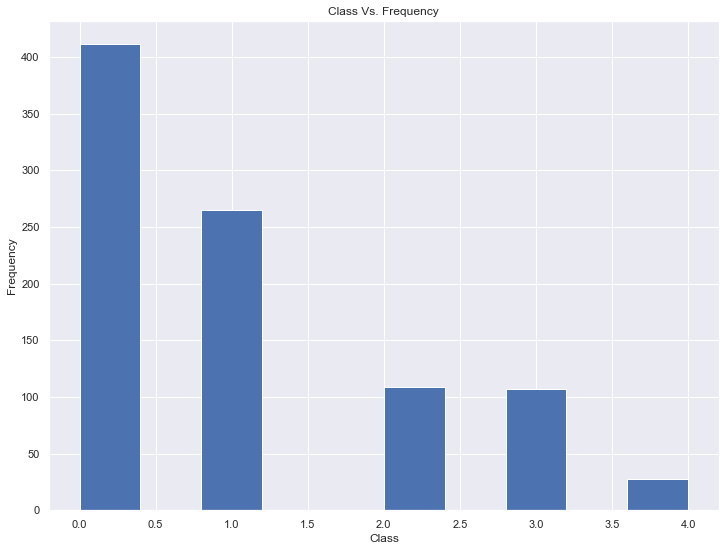

In [21]:
plt.hist(df["class"])
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.title("Class Vs. Frequency")

In [22]:
dupli = df[df.duplicated()]
print(dupli)

     Age  Gender  Chest pain type  Resting blood pressure  Serum cholesterol  \
187   58       1                3                   150.0                219   
605   49       0                2                   110.0                220   

     Fasting blood sugar  Resting electrocardiographic  Maximum heart rate  \
187                    0                             1                 118   
605                    0                             0                 160   

     Exercise induced angina  ST depression  ST segment  \
187                        1            0.0         NaN   
605                        0            0.0         NaN   

     Number of major vessels  Thal  class  
187                      NaN   NaN      2  
605                      NaN   NaN      0  


In [23]:
df_1[:].describe()

,Age,Gender,Chest pain type,Resting blood pressure,Serum cholesterol,Fasting blood sugar,Resting electrocardiographic,Maximum heart rate,Exercise induced angina,ST depression,class
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000,920.000000
mean,53.510870,0.789130,3.250000,132.382174,242.546739,0.150000,0.603261,137.027174,0.400000,0.917174,0.995652
std,9.424685,0.408148,0.930969,17.925276,52.481532,0.357266,0.805443,25.560279,0.490164,1.036872,1.142693
min,28.000000,0.000000,1.000000,80.000000,85.000000,0.000000,0.000000,14.000000,0.000000,0.000000,0.000000
25%,47.000000,1.000000,3.000000,120.000000,217.750000,0.000000,0.000000,120.000000,0.000000,0.000000,0.000000
50%,54.000000,1.000000,4.000000,130.000000,233.000000,0.000000,0.000000,139.000000,0.000000,0.800000,1.000000
75%,60.000000,1.000000,4.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,2.000000
max,77.000000,1.000000,4.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,4.000000


In [24]:
#
#
#

#
#
#
#


In [25]:
import pandas as pd

# Validation methods
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
import random_classifier # the Random Classifier python file in the 'classifiers' folder
import k_nearest_neighbour
# Plotting & utils
import pprint
import matplotlib.pyplot as plt
import numpy as np

In [26]:
X = df_1
y = df_1["class"]

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, # feature matrix
                                                    y, # label vector
                                                    test_size=0.5, # 50% test / 50% traing
                                                    random_state=1, # fixed random seed
                                                    stratify=df_1["class"] # split dataset proportional to classes
                                                   )

# Instantiating model
model = random_classifier.RandomClassifier()
#training model
model = model.fit(X_train, y_train)

#testing model
y_pred = model.predict(X_test)

#printing confusion matrix and accuracy
print(metrics.confusion_matrix(y_test, y_pred))
print("\nAccuracy (Testing):  %0.2f " % (metrics.accuracy_score(y_test, y_pred)))

[[34 37 45 49 41]
 [20 23 29 34 27]
 [ 7 12  6 16 13]
 [12 11  5 11 14]
 [ 3  4  1  5  1]]

Accuracy (Testing):  0.16 


In [28]:
# Splitting dataset for hold-out validation
X_train, X_test, y_train, y_test = train_test_split(X, # feature matrix
                                                    y, # label vector
                                                    test_size=0.4, # 40% test / 60% training
                                                    random_state=1, # fixed random seed
                                                    stratify=df_1["class"] # split dataset proportional to classes
                                                   )

# Instantiating model
model = k_nearest_neighbour.KNNClassifier(k=3)

# Training model
model = model.fit(X_train, y_train)

# Testing model
y_pred = model.predict(X_test)

# Printing out confusion matrix and accuracy
print(metrics.confusion_matrix(y_test, y_pred))
print("\nAccuracy (Testing):  %0.2f " % (metrics.accuracy_score(y_test, y_pred)))

[[102  37  16   7   2]
 [ 32  49  15   9   1]
 [ 13  11  10   6   4]
 [ 17   5  12   7   2]
 [  1   2   3   3   2]]

Accuracy (Testing):  0.46 


<AxesSubplot:xlabel='Class', ylabel='Frequency'>

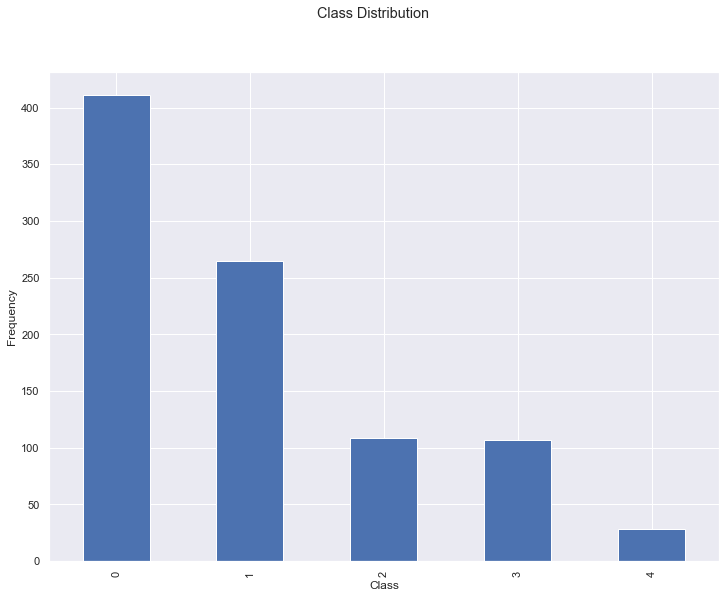

In [29]:
plt.figure()
plt.suptitle('Class Distribution')
plt.ylabel('Frequency')
plt.xlabel('Class')
df['class'].value_counts().plot(kind="bar")

In [30]:
import math
class_thal = [x for x in df["Thal"] if not math.isnan(x)]

411


<ipython-input-31-8eb1c8b6f058>:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


Text(0.5, 1.0, 'Heart disease presence / absence in Dataset')

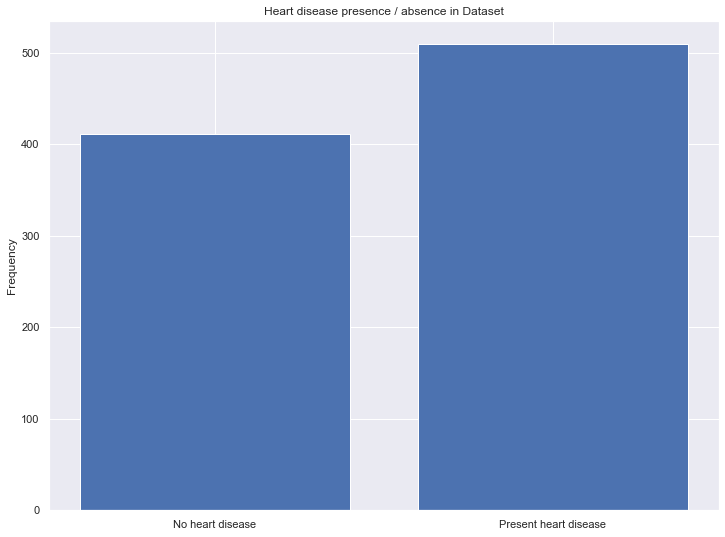

In [31]:
none1 = []
present = []

labels = ["No heart disease", "Present heart disease"]

for i in df["class"]:
    if i > 0:
        present.append(i)
    elif i == 0:
        none1.append(i)

        
nones = len(none1)
presents = len(present)
print(nones)
data = [nones, presents]


plt.bar(range(len(data)), data)
ax = plt.subplot()
ax.set_xticks(range(2))
ax.set_xticklabels(labels)
plt.ylabel("Frequency")
plt.title("Heart disease presence / absence in Dataset")


In [32]:
# Splitting dataset for hold-out validation

X_train, X_test, y_train, y_test = train_test_split(X, # feature matrix
                                                    y, # label vector
                                                    test_size=0.2, # 20% test / 80% traing
                                                    random_state=1, # fixed random seed
                                                    stratify=df_1["class"] # split dataset proportional to classes
                                                   )

# Instantiating model
model = random_classifier.RandomClassifier()

# Training model
model = model.fit(X_train, y_train)


# Testing model
y_pred = model.predict(X_test)

# Printing out confusion matrix and accuracy
print(metrics.confusion_matrix(y_test, y_pred))
print("\nAccuracy (Testing):  %0.2f " % (metrics.accuracy_score(y_test, y_pred)))
print("\nPrecision (Testing):  %0.2f " % (precision_score(y_test, y_pred, average="micro")))


[[12 22 10 17 21]
 [11 14  4 12 12]
 [ 4  2  4  5  7]
 [ 3  7  2  7  2]
 [ 4  1  1  0  0]]

Accuracy (Testing):  0.20 

Precision (Testing):  0.20 


In [33]:
# Splitting dataset for hold-out validation
X_train, X_test, y_train, y_test = train_test_split(X, # feature matrix
                                                    y, # label vector
                                                    test_size=0.2, # 20% test / 80% traing
                                                    random_state=1, # fixed random seed
                                                    stratify=df_1["class"]# split dataset proportional to classes
                                                   )

# Instantiating model
model = k_nearest_neighbour.KNNClassifier(k=3)

# Training model
model = model.fit(X_train, y_train)

# Testing model
y_pred = model.predict(X_test)

# Printing out confusion matrix and accuracy
print(metrics.confusion_matrix(y_test, y_pred))
print("\nAccuracy (Testing):  %0.2f " % (metrics.accuracy_score(y_test, y_pred)))
print("\nPrecision (Testing):  %0.2f " % (precision_score(y_test, y_pred, average="micro")))

[[54 17  8  2  1]
 [17 24  6  6  0]
 [ 7  4  5  6  0]
 [ 5  3  5  6  2]
 [ 0  1  4  1  0]]

Accuracy (Testing):  0.48 

Precision (Testing):  0.48 


In [34]:
# Instantiating model
model = model = random_classifier.RandomClassifier()

# 5-fold cross validation
# StratifiedKFold is used when cv is set to None or an Integer (with a classification model)
scores = cross_validate(model, X, y, cv=5, return_train_score=True, return_estimator=True)

add_result('Random', 'CV', scores['test_score'], scores['fit_time'], scores['score_time'])

# Printing results
print("Accuracy (Training): %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Accuracy (Testing):  %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Accuracy (Training): 0.20 (+/- 0.03)
Accuracy (Testing):  0.18 (+/- 0.05)


In [35]:
# Instantiating model
k = 10
model = k_nearest_neighbour.KNNClassifier(k=k)

# 5-fold cross validation
# StratifiedKFold is used when cv is set to None or an Integer (with a classification model)
scores = cross_validate(model, X, y, cv=5, return_train_score=True, return_estimator=True)

add_result('K-NN (bespoke)', 'CV', scores['test_score'], scores['fit_time'], scores['score_time'])

# Printing results
print("Accuracy (Training): %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Accuracy (Testing):  %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Accuracy (Training): 0.64 (+/- 0.02)
Accuracy (Testing):  0.45 (+/- 0.25)


In [36]:
# Instantiating model
k = 10
model = KNeighborsClassifier(n_neighbors=k)

# 5-fold cross validation
# StratifiedKFold is used when cv is set to None or an Integer (with a classification model)
scores = cross_validate(model, X, y, cv=5, return_train_score=True, return_estimator=True)

add_result('K-NN (sklearn)', 'CV', scores['test_score'], scores['fit_time'], scores['score_time'])

# Printing results
print("Accuracy (Training): %0.2f (+/- %0.2f)" % (scores['train_score'].mean(), scores['train_score'].std() * 2))
print("Accuracy (Testing):  %0.2f (+/- %0.2f)" % (scores['test_score'].mean(), scores['test_score'].std() * 2))

Accuracy (Training): 0.59 (+/- 0.03)
Accuracy (Testing):  0.48 (+/- 0.07)


In [37]:
# Instantiating model
model = random_classifier.RandomClassifier()

# Hold-out-validation
scores_random, fit_time_list, predict_time_list = hold_out_validation(X, y, model, 100, 0.2)

add_result('Random', 'Hold-Out', scores_random, fit_time_list, predict_time_list)

print("Accuracy (Testing):  %0.2f (+/- %0.2f)" % (scores_random.mean(), scores_random.std() * 2))

Accuracy (Testing):  0.20 (+/- 0.06)


In [38]:
# Instantiating model
k = 10
model = k_nearest_neighbour.KNNClassifier(k=k)

# Hold-out-validation
scores_knn_bespoke, fit_time_list, predict_time_list = hold_out_validation(X, y, model, 100, 0.2)

add_result('K-NN (bespoke)', 'Hold-Out', scores_knn_bespoke, fit_time_list, predict_time_list)

print("Accuracy (Testing):  %0.2f (+/- %0.2f)" % (scores_knn_bespoke.mean(), scores_knn_bespoke.std() * 2))

Accuracy (Testing):  0.51 (+/- 0.07)


In [39]:
# Instantiating model
k = 10
model = KNeighborsClassifier(n_neighbors=k)

# Hold-out-validation
scores_knn_sklearn, fit_time_list, predict_time_list = hold_out_validation(X, y, model, 100, 0.2)

add_result('K-NN (sklearn)', 'Hold-Out', scores_knn_sklearn, fit_time_list, predict_time_list)

print("Accuracy (Testing):  %0.2f (+/- %0.2f)" % (scores_knn_sklearn.mean(), scores_knn_sklearn.std() * 2))

Accuracy (Testing):  0.51 (+/- 0.07)


In [40]:
result_df
#
#
#
#
#
#
#
#
# IMPORTANT

,Model,Validation Method,Accuracy,STDEV,Training time (s),Testing time (s)
0,Random,CV,0.181522,0.025860,0.001604,0.002400
1,K-NN (bespoke),CV,0.446739,0.123090,0.001401,0.644185
2,K-NN (sklearn),CV,0.477174,0.034441,0.002402,0.005005
3,Random,Hold-Out,0.202446,0.030302,0.000841,0.001862
4,K-NN (bespoke),Hold-Out,0.511522,0.033141,0.000971,0.693129
5,K-NN (sklearn),Hold-Out,0.508043,0.035601,0.001732,0.004204


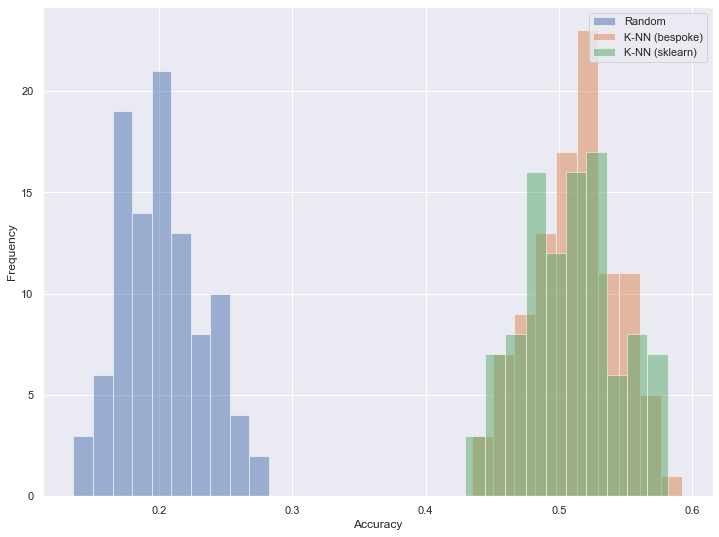

In [41]:
# plotting a histogram of the accuracy for the 3 classifiers
plt.figure()
plt.hist(scores_random, bins=10, alpha=0.5, label='Random')
plt.hist(scores_knn_bespoke, bins=10, alpha=0.5, label='K-NN (bespoke)')
plt.hist(scores_knn_sklearn, bins=10, alpha=0.5, label='K-NN (sklearn)')
plt.legend(loc='upper right')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.show()

In [42]:
gaussian_accuracy = np.array([])
muiltinomial_accuracy = np.array([])
bernoulli_accuracy = np.array([])
num_runs = 100

print("Starting",num_runs,"runs")
for x in range(num_runs):
    
    # splitting the dataset each run, just to get more variation in the results for this example
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, stratify=df_1["class"])
    
    # Gaussian NB
    gaussianNB = GaussianNB()
    gaussianNB = gaussianNB.fit(X_train,y_train)
    y_pred = gaussianNB.predict(X_test)
    gaussian_accuracy = np.append(gaussian_accuracy, metrics.accuracy_score(y_test, y_pred))
    
    # Multinomial NB
    multinomialNB = MultinomialNB()
    multinomialNB = multinomialNB.fit(X_train,y_train)
    y_pred = multinomialNB.predict(X_test)
    muiltinomial_accuracy = np.append(muiltinomial_accuracy, metrics.accuracy_score(y_test, y_pred))
    
    # Bernoulli NB
    bernoulliNB = BernoulliNB()
    bernoulliNB = bernoulliNB.fit(X_train,y_train)
    y_pred = bernoulliNB.predict(X_test)
    bernoulli_accuracy = np.append(bernoulli_accuracy, metrics.accuracy_score(y_test, y_pred))

print("Done...")
print(" - Gaussian accuracy:    %0.2f (+/- %0.2f)" % (gaussian_accuracy.mean(), gaussian_accuracy.std() * 2))
print(" - Multinomial accuracy: %0.2f (+/- %0.2f)" % (muiltinomial_accuracy.mean(), muiltinomial_accuracy.std() * 2))
print(" - Bernoulli accuracy:   %0.2f (+/- %0.2f)" % (bernoulli_accuracy.mean(), bernoulli_accuracy.std() * 2))


Starting 100 runs
Done...
 - Gaussian accuracy:    1.00 (+/- 0.00)
 - Multinomial accuracy: 0.65 (+/- 0.06)
 - Bernoulli accuracy:   0.73 (+/- 0.02)


In [43]:
dt_accuracy = np.array([])
dt_precision = np.array([])
dt_recall = np.array([])

rf_accuracy = np.array([])
rf_precision = np.array([])
rf_recall = np.array([])

nb_accuracy = np.array([])
nb_precision = np.array([])
nb_recall = np.array([])
num_runs = 100

# train and test the DT and RF 1k times and saving the accuracy into the above lists
# PS: you should also capture other metrics for your assignment...
print("Starting",num_runs,"runs")
for x in range(num_runs):
    
    # splitting the dataset each run, just to get more variation in the results for this example
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, stratify=df_1["class"])
    
    # DT with default config
    dt = DecisionTreeClassifier(random_state=None)
    dt = dt.fit(X_train,y_train)
    y_pred = dt.predict(X_test)
    dt_accuracy = np.append(dt_accuracy, metrics.accuracy_score(y_test, y_pred))
    
    # DT with default config precision
    dt = DecisionTreeClassifier(random_state=None)
    dt = dt.fit(X_train,y_train)
    y_pred = dt.predict(X_test)
    dt_precision = np.append(dt_precision, precision_score(y_test, y_pred,average="micro"))
    
    # DT with default config precision
    dt = DecisionTreeClassifier(random_state=None)
    dt = dt.fit(X_train,y_train)
    y_pred = dt.predict(X_test)
    dt_recall = np.append(dt_recall, recall_score(y_test, y_pred,average="micro"))
    #################
    
    # Random Forest with 10 trees (and keeping other config as per default values)
    rf = RandomForestClassifier(random_state=None)
    rf = rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    rf_accuracy = np.append(rf_accuracy, metrics.accuracy_score(y_test, y_pred))
    
    # DT with default config precision
    rf = RandomForestClassifier(random_state=None)
    rf = rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    rf_precision = np.append(rf_precision, precision_score(y_test, y_pred,average="micro"))
    
    # DT with default config precision
    rf = RandomForestClassifier(random_state=None)
    rf = rf.fit(X_train,y_train)
    y_pred = rf.predict(X_test)
    rf_recall = np.append(rf_recall, recall_score(y_test, y_pred,average="micro"))
    ###################
    # Gaussian NB
    gaussianNB = GaussianNB() # Note that Naive Bayes doesn't have the 'random_state' argument
    gaussianNB = gaussianNB.fit(X_train,y_train)
    y_pred = gaussianNB.predict(X_test)
    nb_accuracy = np.append(nb_accuracy, metrics.accuracy_score(y_test, y_pred))
    
    # DT with default config precision
    gaussianNB = GaussianNB() # Note that Naive Bayes doesn't have the 'random_state' argument
    gaussianNB = gaussianNB.fit(X_train,y_train)
    y_pred = gaussianNB.predict(X_test)
    nb_precision = np.append(nb_precision, precision_score(y_test, y_pred,average="micro"))
    
    gaussianNB = GaussianNB() # Note that Naive Bayes doesn't have the 'random_state' argument
    gaussianNB = gaussianNB.fit(X_train,y_train)
    y_pred = gaussianNB.predict(X_test)
    nb_recall = np.append(nb_recall, recall_score(y_test, y_pred,average="micro"))
    #####################
print("Done...")
print(" - DT accuracy: %0.2f (+/- %0.2f)" % (dt_accuracy.mean(), dt_accuracy.std() * 2))
print(" - DT precision: %0.2f (+/- %0.2f)" % (dt_precision.mean(), dt_precision.std() * 2))
print(" - DT recall: %0.2f (+/- %0.2f)" % (dt_recall.mean(), dt_recall.std() * 2))

print(" - RF accuracy: %0.2f (+/- %0.2f)" % (rf_accuracy.mean(), rf_accuracy.std() * 2))
print(" - RF precision: %0.2f (+/- %0.2f)" % (rf_precision.mean(), rf_precision.std() * 2))
print(" - RF recall: %0.2f (+/- %0.2f)" % (rf_recall.mean(), rf_recall.std() * 2))

print(" - NB accuracy: %0.2f (+/- %0.2f)" % (nb_accuracy.mean(), nb_accuracy.std() * 2))
print(" - NB precision: %0.2f (+/- %0.2f)" % (nb_precision.mean(), nb_precision.std() * 2))
print(" - NB recall: %0.2f (+/- %0.2f)" % (nb_recall.mean(), nb_recall.std() * 2))

Starting 100 runs
Done...
 - DT accuracy: 1.00 (+/- 0.00)
 - DT precision: 1.00 (+/- 0.00)
 - DT recall: 1.00 (+/- 0.00)
 - RF accuracy: 0.98 (+/- 0.01)
 - RF precision: 0.98 (+/- 0.01)
 - RF recall: 0.98 (+/- 0.01)
 - NB accuracy: 1.00 (+/- 0.00)
 - NB precision: 1.00 (+/- 0.00)
 - NB recall: 1.00 (+/- 0.00)


Text(0.5, 1.0, 'Naive Bayes')

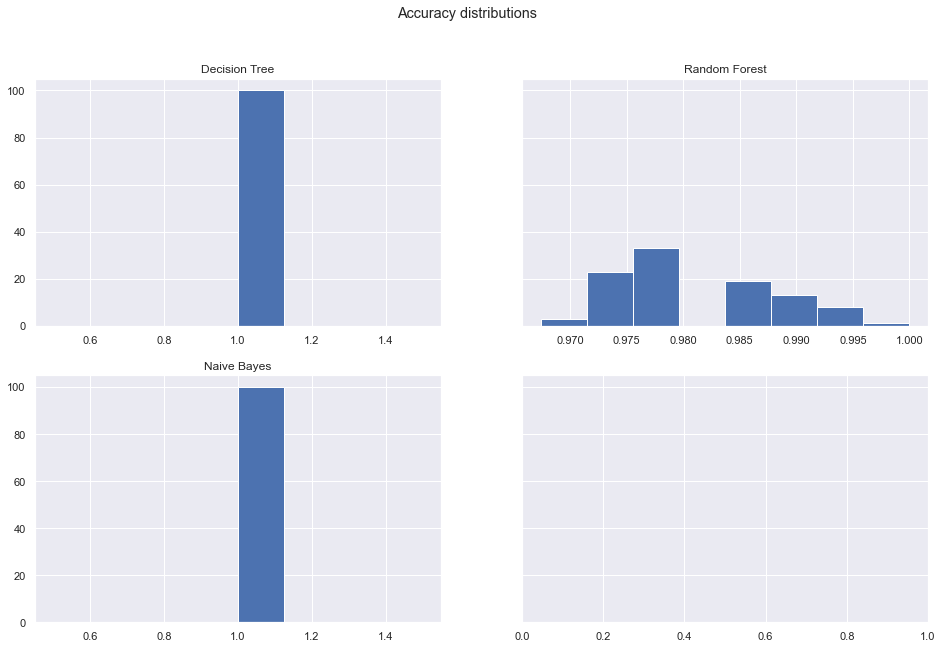

In [44]:
# Setting up figure with two sub-plots to show the distribution of the DT and RF results (accuracy)
fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharey=True)
fig.suptitle('Accuracy distributions')

num_bins = 8

# Adding figure for DT
axs[0][0].hist(dt_accuracy, num_bins)
axs[0][0].set_title('Decision Tree')

# Adding figure for RF
axs[0][1].hist(rf_accuracy, num_bins)
axs[0][1].set_title('Random Forest')

# Adding figure for NB
axs[1][0].hist(nb_accuracy, num_bins)
axs[1][0].set_title('Naive Bayes')

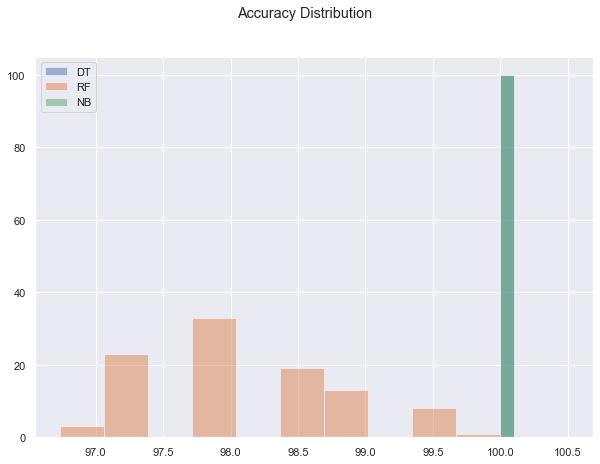

In [45]:
plt.figure(figsize=(10, 7))
plt.suptitle('Accuracy Distribution')
bins = np.linspace(70, 100, 20)

plt.hist(dt_accuracy*100, alpha=0.5, label='DT')
plt.hist(rf_accuracy*100, alpha=0.5, label='RF')
plt.hist(nb_accuracy*100, alpha=0.5, label='NB')

plt.legend(loc='upper left')
plt.show()

In [46]:
# Checking for normality and statistical significance
# If the p value >= alpha, then normal.
# Alpha value of 0.05 is common.
from scipy.stats import shapiro     # Shapiro Wilk
from scipy.stats import normaltest  # D’Agostino’s K^2
from scipy.stats import anderson    # Anderson-Darling

a = 0.05

print("DT normality tests")
stat, p = shapiro(dt_accuracy)
print(' * Shapiro:    W = %0.2f, p-value = %0.2f' % (stat, p))
if (p >= a):
    print("   - Looks NORMAL!")
else:
    print("   - Doesn't look normal :(")
stat, p = normaltest(dt_accuracy)
print(' * D’Agostino: W = %0.2f, p-value = %0.2f' % (stat, p))
if (p >= a):
    print("   - Looks NORMAL!")
else:
    print("   - Doesn't look normal :(")

print()

print("RF normality tests")
stat, p = shapiro(rf_accuracy)
print(' * Shapiro:    W = %0.2f, p-value = %0.2f' % (stat, p))
if (p >= a):
    print("   - Looks NORMAL!")
else:
    print("   - Doesn't look normal :(")
stat, p = normaltest(rf_accuracy)
print(' * D’Agostino: W = %0.2f, p-value = %0.2f' % (stat, p))
if (p >= a):
    print("   - Looks NORMAL!")
else:
    print("   - Doesn't look normal :(")

print()

print("NB normality tests")
stat, p = shapiro(nb_accuracy)
print(' * Shapiro:    W = %0.2f, p-value = %0.2f' % (stat, p))
if (p >= a):
    print("   - Looks NORMAL!")
else:
    print("   - Doesn't look normal :(")
stat, p = normaltest(nb_accuracy)
print(' * D’Agostino: W = %0.2f, p-value = %0.2f' % (stat, p))
if (p >= a):
    print("   - Looks NORMAL!")
else:
    print("   - Doesn't look normal :(")

# and another one, but just for NB
result = anderson(nb_accuracy)
print(' * Anderson-Darling statistic: %.3f' % result.statistic)
for i in range(len(result.critical_values)):
	sl, cv = result.significance_level[i], result.critical_values[i]
	if result.statistic < result.critical_values[i]:
		print('    %.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
	else:
		print('    %.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))


DT normality tests
 * Shapiro:    W = 1.00, p-value = 1.00
   - Looks NORMAL!
 * D’Agostino: W = 498.15, p-value = 0.00
   - Doesn't look normal :(

RF normality tests
 * Shapiro:    W = 0.92, p-value = 0.00
   - Doesn't look normal :(
 * D’Agostino: W = 5.02, p-value = 0.08
   - Looks NORMAL!

NB normality tests
 * Shapiro:    W = 1.00, p-value = 1.00
   - Looks NORMAL!
 * D’Agostino: W = 498.15, p-value = 0.00
   - Doesn't look normal :(
 * Anderson-Darling statistic: nan
    15.000: 0.555, data does not look normal (reject H0)
    10.000: 0.632, data does not look normal (reject H0)
    5.000: 0.759, data does not look normal (reject H0)
    2.500: 0.885, data does not look normal (reject H0)
    1.000: 1.053, data does not look normal (reject H0)


C:\Users\Dawid\anaconda3\lib\site-packages\scipy\stats\morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\Users\Dawid\anaconda3\lib\site-packages\scipy\stats\morestats.py:1785: RuntimeWarning: invalid value encountered in true_divide
  w = (y - xbar) / s


In [47]:
# In my tests, the above results do not seem to be normally distributed, 
# so the Student T-Test would only be vaguely reliable with a very large sample size.
# Better still, we need to consider using another significance test that doesn't assume normality
# See, e.g., https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

from scipy.stats import ttest_ind    # independent student t-test; assumes normality
from scipy.stats import mannwhitneyu # non-parametric; doesn't assume normality

stat, p = ttest_ind(dt_accuracy, rf_accuracy)
print('T-Test: stat = %0.2f, p-value = %f' % (stat, p))
if p < 0.05:
    print(" - The performance difference appears significant")
else:
    print(" - The performance difference is NOT significant")

stat, p = mannwhitneyu(dt_accuracy, rf_accuracy)
print('\nMann-Whitney U: stat = %0.2f, p-value = %f' % (stat, p))
if p < 0.05:
    print(" - The performance difference appears significant")
else:
    print(" - The performance difference is NOT significant")

T-Test: stat = 26.80, p-value = 0.000000
 - The performance difference appears significant

Mann-Whitney U: stat = 50.00, p-value = 0.000000
 - The performance difference appears significant


In [48]:
array = [x for x in range(1,101)]

for x in array:
    if x % 3 == 0 and x % 5 ==0:
        array[x-1] = "FizzBuzz"
    elif x % 3 == 0:
        array[x-1] = "fizz"
    elif x % 5 == 0:
        array[x-1] = "buzz"
    else:
        array[x-1] = array[x-1]
    
array

[1,
 2,
 'fizz',
 4,
 'buzz',
 'fizz',
 7,
 8,
 'fizz',
 'buzz',
 11,
 'fizz',
 13,
 14,
 'FizzBuzz',
 16,
 17,
 'fizz',
 19,
 'buzz',
 'fizz',
 22,
 23,
 'fizz',
 'buzz',
 26,
 'fizz',
 28,
 29,
 'FizzBuzz',
 31,
 32,
 'fizz',
 34,
 'buzz',
 'fizz',
 37,
 38,
 'fizz',
 'buzz',
 41,
 'fizz',
 43,
 44,
 'FizzBuzz',
 46,
 47,
 'fizz',
 49,
 'buzz',
 'fizz',
 52,
 53,
 'fizz',
 'buzz',
 56,
 'fizz',
 58,
 59,
 'FizzBuzz',
 61,
 62,
 'fizz',
 64,
 'buzz',
 'fizz',
 67,
 68,
 'fizz',
 'buzz',
 71,
 'fizz',
 73,
 74,
 'FizzBuzz',
 76,
 77,
 'fizz',
 79,
 'buzz',
 'fizz',
 82,
 83,
 'fizz',
 'buzz',
 86,
 'fizz',
 88,
 89,
 'FizzBuzz',
 91,
 92,
 'fizz',
 94,
 'buzz',
 'fizz',
 97,
 98,
 'fizz',
 'buzz']

In [49]:
df_1.head(30)

,Age,Gender,Chest pain type,Resting blood pressure,Serum cholesterol,Fasting blood sugar,Resting electrocardiographic,Maximum heart rate,Exercise induced angina,ST depression,class
0,63,1,4,140.0,260,0,1,112,1,3.0,2
1,44,1,4,130.0,209,0,1,127,0,0.0,0
2,60,1,4,132.0,218,0,1,140,1,1.5,2
3,55,1,4,142.0,228,0,1,149,1,2.5,1
4,66,1,3,110.0,213,1,2,99,1,1.3,0
5,66,1,3,120.0,220,0,1,120,0,0.0,0
6,65,1,4,150.0,236,1,1,105,1,0.0,3
7,60,1,3,180.0,220,0,1,140,1,1.5,0
8,60,1,3,120.0,224,0,0,141,1,2.0,3
9,60,1,2,160.0,267,1,1,157,0,0.5,1


In [50]:
df_1.isnull().sum()

Age                             0
Gender                          0
Chest pain type                 0
Resting blood pressure          0
Serum cholesterol               0
Fasting blood sugar             0
Resting electrocardiographic    0
Maximum heart rate              0
Exercise induced angina         0
ST depression                   0
class                           0
dtype: int64

In [51]:
# AVERAGE FOR SERUM CHOLESTEROL WITHOUT 0.
avg = []


for x in df["Serum cholesterol"]:
    if x == 0:
        continue
    elif x > 0:
        avg.append(x)


a = len(avg) 
#v1 = sum(avg)

summ = sum(avg)
summ

avg1 = summ/a

avg1

242.5467391304348

In [52]:
# Visualising the Decision Tree
def visualise_tree(model, feature_names, class_labels):
    """
    A function to visualise a decision tree model. This requires graphviz to be installed.
    :param model: the decision tree model
    :param feature_list: a list of names for the features
    :param class_labels: a list of names for the class labels
    """
    graph = Source(tree.export_graphviz(model, out_file=None
       , feature_names=feature_names, class_names=class_labels
       , filled = True))
    graph_svg = SVG(graph.pipe(format='svg'))
    display(graph_svg)

In [53]:
# Utility function to report best scores
def report(results, rank_metric='score', n_top=3):
    """
    Utility function to report best scores.
    :param results: the cv_results_ data structure from the optimisation algorithm
    :param rank_metric: name of the metric to report results for
    :param n_top: the number of top results to report
    """
    print("\nModels ranked according to", rank_metric)
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_" + rank_metric] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.2f} (+/- {1:.2f})".format(
                  results["mean_test_" + rank_metric][candidate],
                  results["std_test_" + rank_metric][candidate]*2))
            print("Params: {0}".format(results['params'][candidate]))
            print("")

# instantiating the model
model = DecisionTreeClassifier()

# defining parameter grid
param_grid = {"max_depth": [2, 4, 6, 8, None],
              "max_features": [2, 4, 6, 8, 10],
              "min_samples_split": [2, 4, 6, 8, 10],
              "criterion": ["gini", "entropy"],
              "splitter": ["best", "random"]}

# defining multiple metrics for scoring
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'prec_macro': make_scorer(precision_score, average='macro', zero_division=0), 
    'rec_macro': make_scorer(recall_score, average='macro', zero_division=0)
}

# run grid search
print("\n> STARTING GRID SEARCH ...")
n_folds = 10
grid_search = GridSearchCV(model, param_grid=param_grid, cv=n_folds, scoring=scoring, refit='prec_macro')
start = time()
grid_search.fit(X, y)

print("> GRID SEARCH COMPLETE")
print("\nGridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

# Get the best model according to each of the 3 metrics used
report(grid_search.cv_results_, 'accuracy', n_top=1)
report(grid_search.cv_results_, 'prec_macro', n_top=1)
report(grid_search.cv_results_, 'rec_macro', n_top=1)

try:
    print("Best score: %0.2f " % (grid_search.best_score_))
except:
    print("Best score not available (refit set to False presumably)")


> STARTING GRID SEARCH ...
> GRID SEARCH COMPLETE

GridSearchCV took 17.12 seconds for 500 candidate parameter settings.

Models ranked according to accuracy
Model with rank: 1
Mean validation score: 1.00 (+/- 0.00)
Params: {'criterion': 'gini', 'max_depth': 6, 'max_features': 10, 'min_samples_split': 2, 'splitter': 'random'}

Model with rank: 1
Mean validation score: 1.00 (+/- 0.00)
Params: {'criterion': 'gini', 'max_depth': 6, 'max_features': 10, 'min_samples_split': 4, 'splitter': 'best'}

Model with rank: 1
Mean validation score: 1.00 (+/- 0.00)
Params: {'criterion': 'gini', 'max_depth': 6, 'max_features': 10, 'min_samples_split': 6, 'splitter': 'best'}

Model with rank: 1
Mean validation score: 1.00 (+/- 0.00)
Params: {'criterion': 'gini', 'max_depth': 6, 'max_features': 10, 'min_samples_split': 8, 'splitter': 'best'}

Model with rank: 1
Mean validation score: 1.00 (+/- 0.00)
Params: {'criterion': 'gini', 'max_depth': 6, 'max_features': 10, 'min_samples_split': 10, 'splitter': 'r

In [54]:
# instantiating the model
model = DecisionTreeClassifier()

# specify parameters and distributions to sample from
param_dict = {"max_depth": [2, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "criterion": ["gini", "entropy"],
              "splitter": ["best", "random"]}

# run random search
print("> STARTING RANDOM SEARCH ...")
n_iter_search = 20
n_folds = 10

random_search = RandomizedSearchCV(model, param_distributions=param_dict,
                                   n_iter=n_iter_search, cv=n_folds)

start_time = time()
random_search.fit(X, y)
end_time = time()


print("> RANDOM SEARCH COMPLETE")

print("\nRandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((end_time - start_time), n_iter_search))
report(random_search.cv_results_)

> STARTING RANDOM SEARCH ...
> RANDOM SEARCH COMPLETE

RandomizedSearchCV took 0.54 seconds for 20 candidates parameter settings.

Models ranked according to score
Model with rank: 1
Mean validation score: 1.00 (+/- 0.00)
Params: {'criterion': 'entropy', 'max_depth': None, 'max_features': 10, 'min_samples_split': 10, 'splitter': 'random'}

Model with rank: 2
Mean validation score: 1.00 (+/- 0.01)
Params: {'criterion': 'gini', 'max_depth': None, 'max_features': 10, 'min_samples_split': 7, 'splitter': 'best'}

Model with rank: 2
Mean validation score: 1.00 (+/- 0.01)
Params: {'criterion': 'gini', 'max_depth': None, 'max_features': 9, 'min_samples_split': 2, 'splitter': 'best'}



In [55]:
# Instantiating classifier (with default hyper-parameter values)
model = DecisionTreeClassifier()

# Instantiating (setting up) RFE
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')

start_time = time()
rfecv.fit(X, y)
end_time = time()

# Printing out the results
print("RFECV took %.2f seconds to identify %d features" % 
      ((end_time - start_time), rfecv.n_features_))
print(rfecv.ranking_)

dfname = []
for x in df_1:
    dfname.append(x)
    

RFECV took 0.05 seconds to identify 1 features
[11 10  9  8  7  6  5  4  3  2  1]


In [56]:
# Creating a DataFrame to display the original columns and their ranking
feature_ranking_df = pd.DataFrame()
feature_ranking_df['feature'] = dfname
feature_ranking_df['rank'] = rfecv.ranking_

feature_ranking_df = feature_ranking_df.sort_values(by='rank', ascending=True)
feature_ranking_df

,feature,rank
10,class,1
9,ST depression,2
8,Exercise induced angina,3
7,Maximum heart rate,4
6,Resting electrocardiographic,5
5,Fasting blood sugar,6
4,Serum cholesterol,7
3,Resting blood pressure,8
2,Chest pain type,9
1,Gender,10


<AxesSubplot:title={'center':'RF Feature Importance'}>

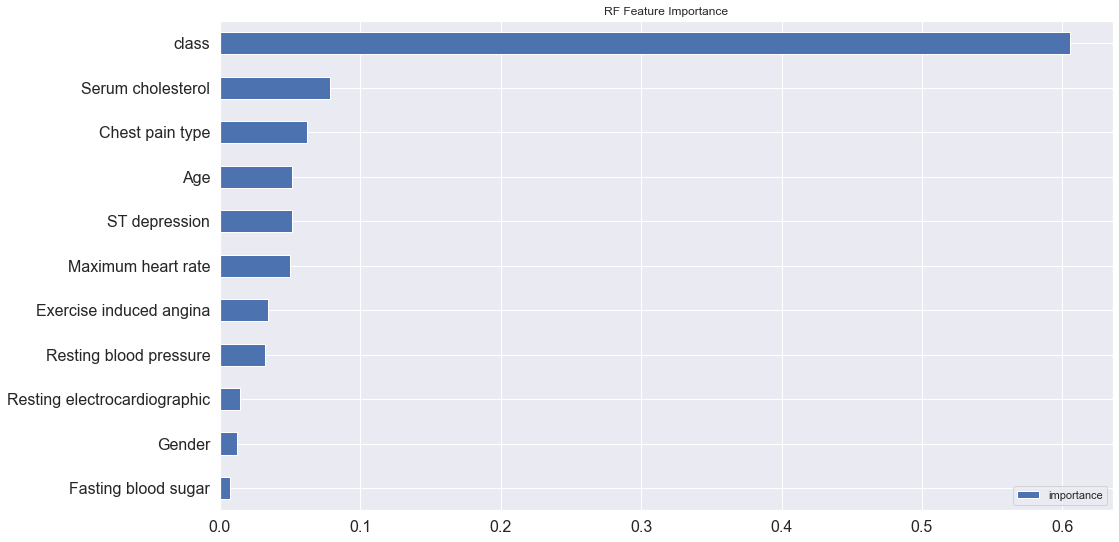

In [57]:
# Instantiating RandomForest classifier (with default hyper-parameter values)
model = RandomForestClassifier(n_estimators=200,random_state=None)

# 5-fold cross validation, returning a trained model
scores = cross_validate(model, X, y, cv=5, return_estimator=True)

# Getting the trained model from the 1st fold
estimator = scores['estimator'][0]

# Creating a DataFrame to display the original columns and their importance
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = dfname
feature_importance_df['importance'] = estimator.feature_importances_

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=True)
#feature_importance_df


feature_importance_df.plot(kind='barh',
                           x='feature', 
                           y='importance',
                           title='RF Feature Importance',
                           xlabel='',
                           figsize=(16, 9),
                           fontsize=16)